In [1]:
# Sample API
import flowx
import simulation
import matplotlib.pyplot as plt
from scipy.interpolate import griddata 
import numpy
import sys
#%matplotlib notebook
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 800, 400
xmin, xmax = -10.0, 30.0
ymin, ymax = -10.0, 10.0

Re   = 100.0
dt   = 1e-1
tmax = 10.

ibm_x = 0.0
ibm_y = 0.0
ibm_r = 0.5


# Define cell-centered variable names
center_vars = ['pres', 'divv']
face_vars   = ['velc', 'hvar']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'outflow', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [1.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'neumann', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=10.0, dt=0.01, Re=100.0)

In [3]:
simulation.set_initial_velocity(gridc, gridx, gridy, 'velc', 'pres')

------------ Time = 0.0 ---------------
Number of poisson iterations    : None
Final poisson residual : 0.0
Max, Min, U   : 1.0, -1.0
Max, Min, V   : 0.0, 0.0
Max, Min, P   : 0.0, 0.0
Max, Min, DIV : 0.0, 0.0




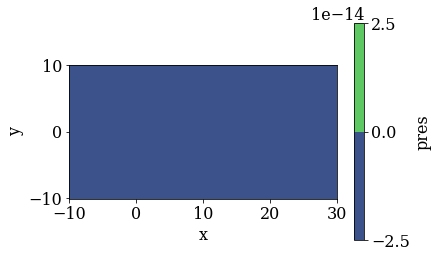

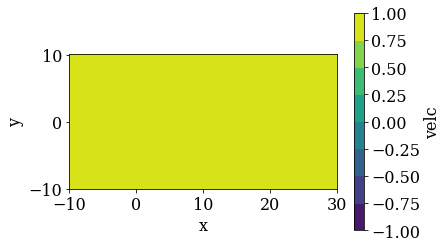

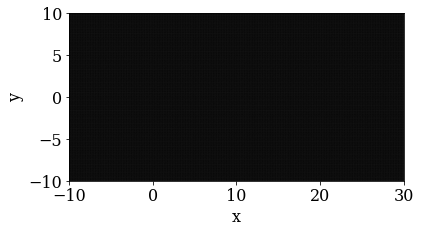

------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : None
Final poisson residual : 3.3867198714813264e-11
Max, Min, U   : 1.0755977705285757, -1.0
Max, Min, V   : 0.1363521335994331, -0.13635213359943313
Max, Min, P   : 1.2886449680721892, -0.5088382857333693
Max, Min, DIV : 8.500145032286355e-15, -8.42641928455734e-15


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.4420760853975775e-11
Max, Min, U   : 1.1038521506583054, -1.0
Max, Min, V   : 0.16155405822294475, -0.1615540582229448
Max, Min, P   : 1.0856687250404657, -0.24762111020465202
Max, Min, DIV : 9.899850036965141e-15, -6.573517771779613e-15


------------ Time = 0.3000000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.1253021385600285e-11
Max, Min, U   : 1.123512924835365, -1.0
Max, Min, V   : 0.16772775874755597, -0.16772775874755602
Max, Min, P   : 1.0105208104126997, -0

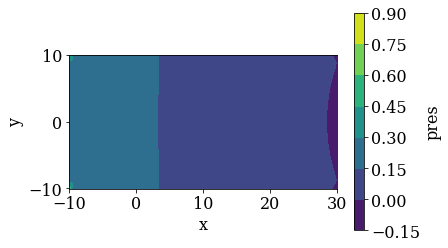

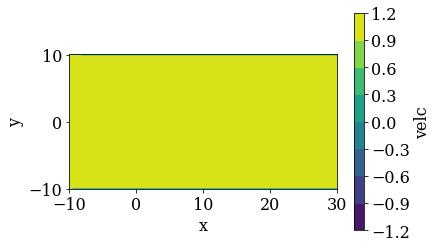

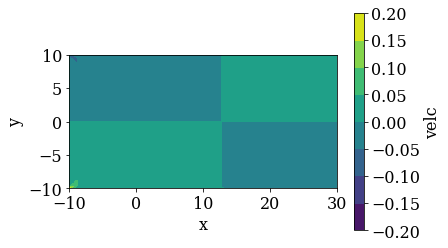

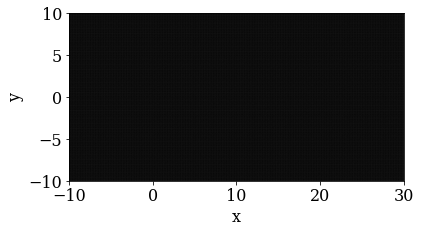

------------ Time = 1.1000000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.7961820997526167e-11
Max, Min, U   : 1.149502545936608, -1.0
Max, Min, V   : 0.16880301885916088, -0.16880301885916102
Max, Min, P   : 0.8945080315775199, -0.000845008357987205
Max, Min, DIV : 5.7245874707234634e-15, -5.898059818321144e-15


------------ Time = 1.2000000000000008 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.8004357330666588e-11
Max, Min, U   : 1.1494724947087762, -1.0
Max, Min, V   : 0.16885042956545745, -0.1688504295654575
Max, Min, P   : 0.8923059808918913, 0.006963810317828123
Max, Min, DIV : 6.7307270867900115e-15, -5.880712583561376e-15


------------ Time = 1.300000000000001 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.7982548929519824e-11
Max, Min, U   : 1.149386046968562, -1.0
Max, Min, V   : 0.16888857218154738, -0.16888857218154724
Max, Min, P   : 0.8892226998724106, 

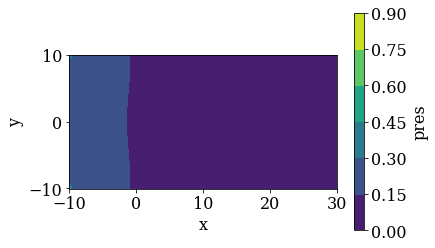

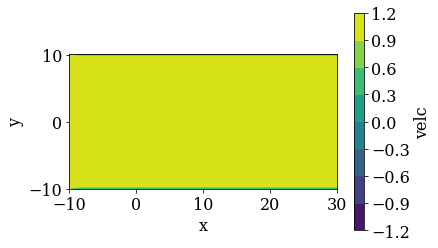

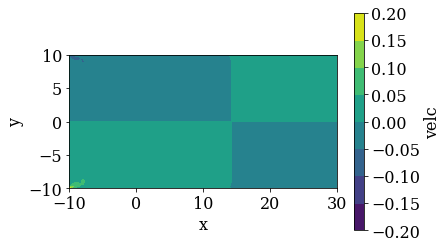

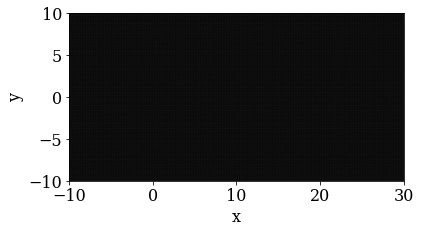

------------ Time = 2.099999999999999 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.5676112087078498e-11
Max, Min, U   : 1.1487193581110997, -1.0
Max, Min, V   : 0.16903751616941703, -0.169037516169417
Max, Min, P   : 0.8570338365307316, 0.020044749092329173
Max, Min, DIV : 5.438900198273533e-15, -5.65303012733942e-15


------------ Time = 2.199999999999997 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.5012117221558413e-11
Max, Min, U   : 1.1486654574235085, -1.0
Max, Min, V   : 0.1690466775957222, -0.16904667759572223
Max, Min, P   : 0.851789954474271, 0.017923253496322594
Max, Min, DIV : 5.700735022928782e-15, -6.88793640180041e-15


------------ Time = 2.299999999999995 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.5129105233366977e-11
Max, Min, U   : 1.1486166427673479, -1.0
Max, Min, V   : 0.16905479569671306, -0.16905479569671317
Max, Min, P   : 0.8518360798644242, 0.020870

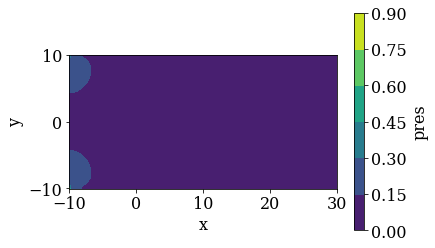

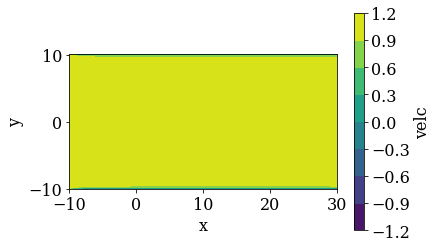

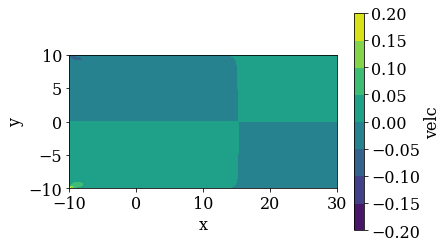

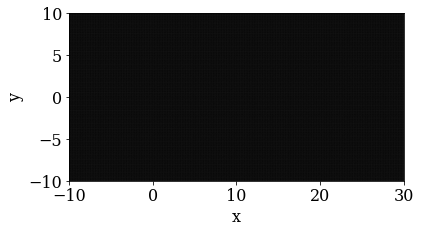

------------ Time = 3.099999999999978 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2652951331040484e-11
Max, Min, U   : 1.1483533580809828, -1.0
Max, Min, V   : 0.16909613390962477, -0.16909613390962472
Max, Min, P   : 0.8277747408515379, 0.014284991655463172
Max, Min, DIV : 6.0021432268797525e-15, -5.7245874707234634e-15


------------ Time = 3.1999999999999758 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2563215671518273e-11
Max, Min, U   : 1.1483313564534816, -1.0
Max, Min, V   : 0.16909942694374472, -0.16909942694374472
Max, Min, P   : 0.8266007318256585, 0.014772894604429005
Max, Min, DIV : 5.204170427930421e-15, -5.4817261840867104e-15


------------ Time = 3.2999999999999736 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.2580486030704354e-11
Max, Min, U   : 1.1483110058219217, -1.0
Max, Min, V   : 0.1691024531536695, -0.16910245315366948
Max, Min, P   : 0.8262205680896608

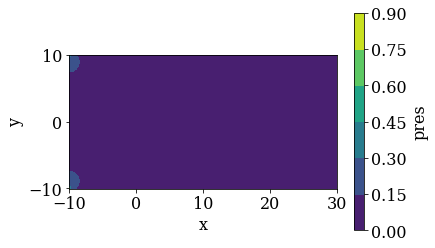

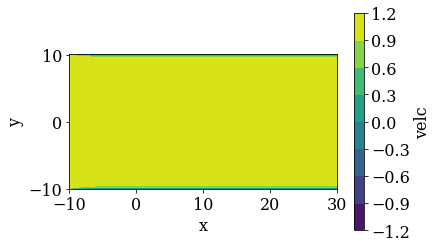

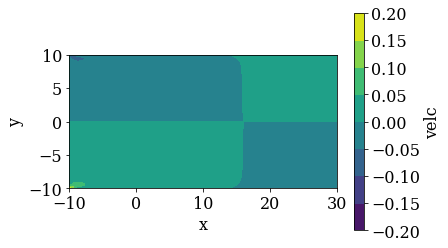

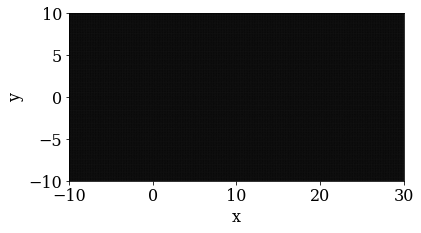

------------ Time = 4.099999999999957 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.0446751780591678e-11
Max, Min, U   : 1.1481918292874043, -1.0
Max, Min, V   : 0.16911981203730042, -0.16911981203730042
Max, Min, P   : 0.8069072962009277, 0.006830533320665955
Max, Min, DIV : 5.065392549852277e-15, -5.2388648974499574e-15


------------ Time = 4.199999999999955 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.0319923578040955e-11
Max, Min, U   : 1.1481809425536442, -1.0
Max, Min, V   : 0.1691213679786529, -0.16912136797865296
Max, Min, P   : 0.8055189463398731, 0.006474709926678526
Max, Min, DIV : 5.152128723651117e-15, -5.828670879282072e-15


------------ Time = 4.299999999999953 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.0413171156654962e-11
Max, Min, U   : 1.1481707122772473, -1.0
Max, Min, V   : 0.16912282568128478, -0.16912282568128467
Max, Min, P   : 0.8064080150002876, 0.

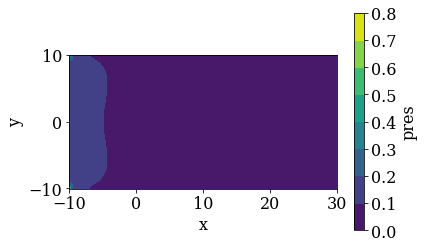

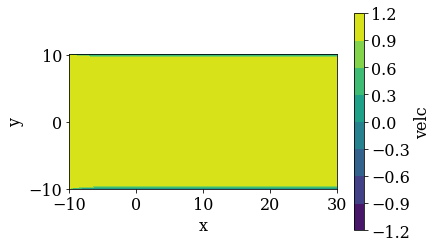

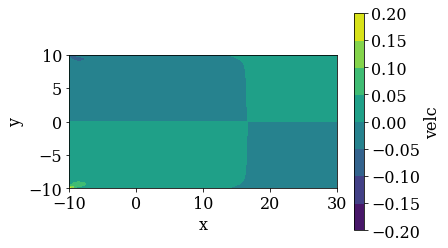

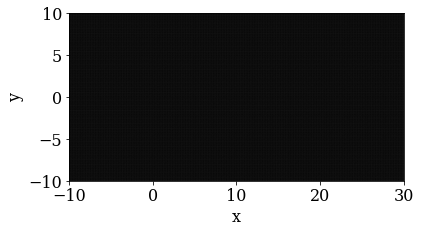

------------ Time = 5.099999999999936 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.552152239032776e-12
Max, Min, U   : 1.1481072201518892, -1.0
Max, Min, V   : 0.16913177791754422, -0.16913177791754408
Max, Min, P   : 0.7980534346062074, 0.00665998471411325
Max, Min, DIV : 5.098325190841524e-15, -5.7592819402429996e-15


------------ Time = 5.199999999999934 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.322482290044185e-12
Max, Min, U   : 1.1481010684032675, -1.0
Max, Min, V   : 0.16913263668771825, -0.16913263668771822
Max, Min, P   : 0.7961496741824646, 0.005457824348494701
Max, Min, DIV : 5.290906601729262e-15, -4.926614671774132e-15


------------ Time = 5.299999999999931 ---------------
Number of poisson iterations    : None
Final poisson residual : 9.058870749017847e-12
Max, Min, U   : 1.1480952258337185, -1.0
Max, Min, V   : 0.16913345089204368, -0.1691334508920437
Max, Min, P   : 0.7940315173570612, 0.0040

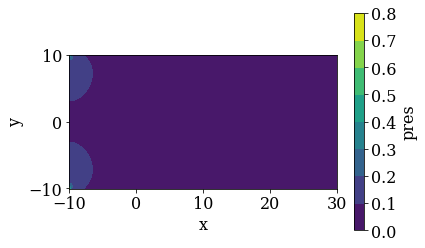

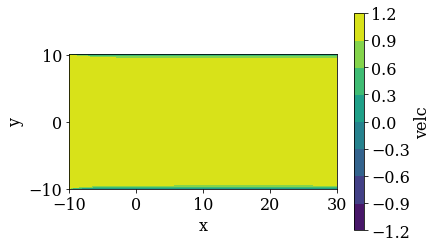

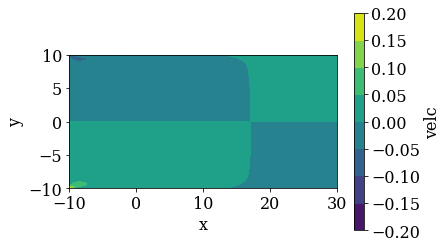

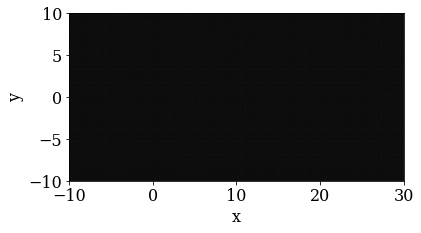

------------ Time = 6.099999999999914 ---------------
Number of poisson iterations    : None
Final poisson residual : 8.511879362117646e-12
Max, Min, U   : 1.1480574856755856, -1.0
Max, Min, V   : 0.1691386771926056, -0.16913867719260556
Max, Min, P   : 0.7888174936700401, 0.003481197564870495
Max, Min, DIV : 4.9960036108132044e-15, -5.160802341031001e-15


------------ Time = 6.199999999999912 ---------------
Number of poisson iterations    : None
Final poisson residual : 8.44840577660294e-12
Max, Min, U   : 1.148053679393331, -1.0
Max, Min, V   : 0.1691392010969864, -0.1691392010969864
Max, Min, P   : 0.7886078967682779, 0.0037769440711896917
Max, Min, DIV : 5.134781488891349e-15, -5.35162192338845e-15


------------ Time = 6.29999999999991 ---------------
Number of poisson iterations    : None
Final poisson residual : 8.222826432921594e-12
Max, Min, U   : 1.1480500373661369, -1.0
Max, Min, V   : 0.16913970184121419, -0.1691397018412141
Max, Min, P   : 0.7865828861750999, 0.002242113

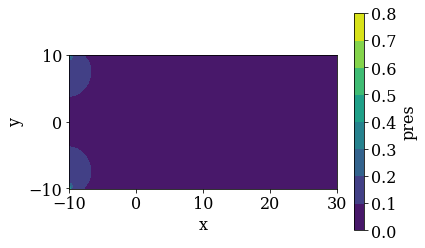

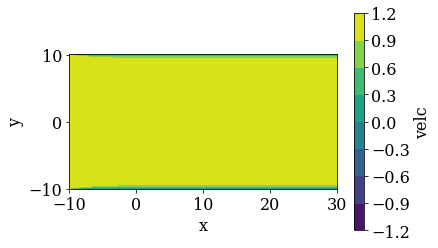

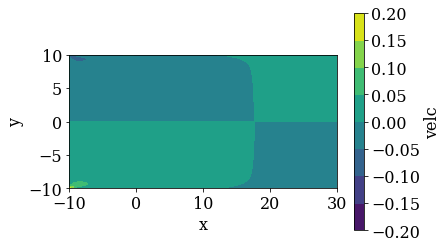

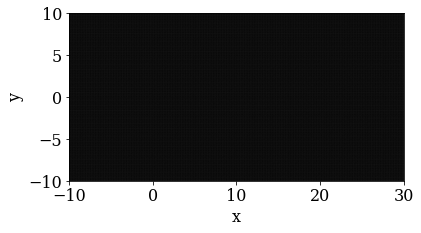

------------ Time = 7.099999999999893 ---------------
Number of poisson iterations    : None
Final poisson residual : 8.326907501068134e-12
Max, Min, U   : 1.1480258268830221, -1.0
Max, Min, V   : 0.1691430167289946, -0.16914301672899468
Max, Min, P   : 0.7874567458398611, 0.006559150510862923
Max, Min, DIV : 5.134781488891349e-15, -4.718447854656915e-15


------------ Time = 7.199999999999891 ---------------
Number of poisson iterations    : None
Final poisson residual : 8.01151511356861e-12
Max, Min, U   : 1.1480233141047942, -1.0
Max, Min, V   : 0.16914335938786396, -0.1691433593878638
Max, Min, P   : 0.7845733488579663, 0.004053728556744845
Max, Min, DIV : 4.961309141293668e-15, -5.0306980803327406e-15


------------ Time = 7.299999999999889 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.93883489303949e-12
Max, Min, U   : 1.1480208966121612, -1.0
Max, Min, V   : 0.16914368880365238, -0.1691436888036524
Max, Min, P   : 0.7841489546978326, 0.0039971

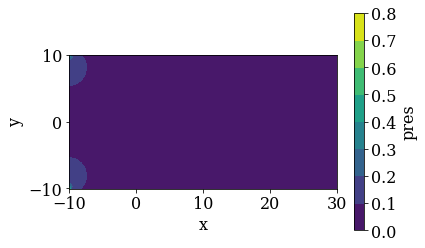

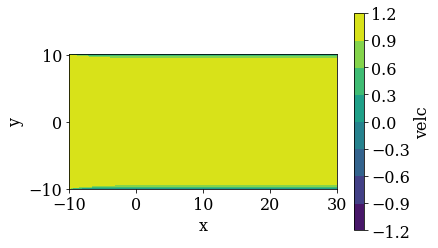

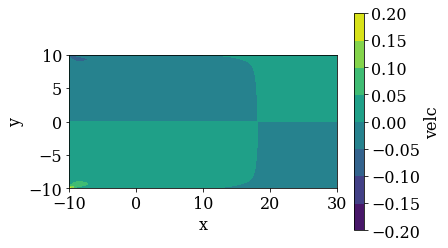

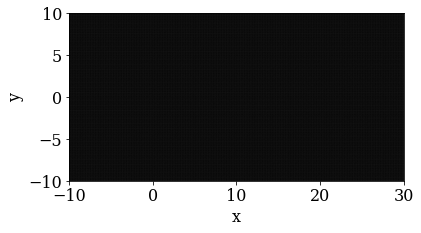

------------ Time = 8.099999999999872 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.610801278682298e-12
Max, Min, U   : 1.1480044789740902, -1.0
Max, Min, V   : 0.16914591939174556, -0.1691459193917456
Max, Min, P   : 0.7812546746381925, 0.0037190763368081655
Max, Min, DIV : 5.117434254131581e-15, -5.689893001203927e-15


------------ Time = 8.19999999999987 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.575037632163977e-12
Max, Min, U   : 1.1480027382510511, -1.0
Max, Min, V   : 0.169146155220034, -0.16914615522003404
Max, Min, P   : 0.7810310653194249, 0.0037861615455051117
Max, Min, DIV : 5.0984607161130846e-15, -4.85722573273506e-15


------------ Time = 8.299999999999867 ---------------
Number of poisson iterations    : None
Final poisson residual : 7.204546713091103e-12
Max, Min, U   : 1.1480010565997558, -1.0
Max, Min, V   : 0.16914638292088194, -0.16914638292088208
Max, Min, P   : 0.7777627692908752, 0.00080

In [ ]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

poisson_options = dict(maxiter = 2000, tol = 1e-9)
poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')


# Compute mass in the domain
Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
        simulation.get_qin(gridy, 'velc', bc_type_v['velc']))

# Update the outflow boundary velocity using a convective equation.
simulation.update_outflow_bc(gridx, 'velc', dt)

# Predictor Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

# Divergence Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')

# Compute mass out of the domain
Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
        simulation.get_qout(gridy, 'velc', bc_type_v['velc']))

# Rescale velocity at outflow and update BC for corrector step
simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                                    Qin, Qout) 
simulation.update_outflow_bc(gridx, 'velc', dt, convvel=0.0)

# Solve the pressure Poisson equation 
scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                                poisson_options)

# Corrector Step
flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')

# Display stats
if scalars.variable['nstep'] % 10 == 0:
    flowx.io.display_stats(scalars)  

if scalars.variable['nstep'] % 100 == 0:
    flowx.io.plot_contour(gridc, 'pres')
    flowx.io.plot_contour(gridx, 'velc')
    flowx.io.plot_vector(gridx,gridy,'velc')

scalars.advance()
    

while scalars.variable['time'] <= scalars.variable['tmax']:

    # Compute mass in the domain
    Qin = (simulation.get_qin(gridx, 'velc', bc_type_u['velc']) +
            simulation.get_qin(gridy, 'velc', bc_type_v['velc']))

    # Update the outflow boundary velocity using a convective equation.
    simulation.update_outflow_bc(gridx, 'velc', dt)

    # Predictor Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

    # Divergence Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'divergence')

    # Compute mass out of the domain
    Qout = (simulation.get_qout(gridx, 'velc', bc_type_u['velc']) +
            simulation.get_qout(gridy, 'velc', bc_type_v['velc']))

    # Rescale velocity at outflow and update BC for corrector step
    simulation.rescale_velocity(gridx, 'velc', bc_type_u['velc'],
                                    Qin, Qout) 
    simulation.update_outflow_bc(gridx, 'velc', dt, convvel=0.0)

    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                                 poisson_options)

    # Corrector Step
    flowx.ins.ab2(gridc, gridx, gridy, scalars, ins_vars, 'corrector')

    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)  

    if scalars.variable['nstep'] % 100 == 0:
        flowx.io.plot_contour(gridc, 'pres')
        flowx.io.plot_contour(gridx, 'velc')
        flowx.io.plot_contour(gridy, 'velc')
        flowx.io.plot_vector(gridx,gridy,'velc')

    scalars.advance()

In [ ]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridy, 'velc')
flowx.io.plot_vector(gridx,gridy,'velc')